# Imports

In [4]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import zipfile
import os
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# POS Cash dataset

In [5]:
#loading the dataset
cash = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")

In [20]:
application_train = pd.read_csv("home-credit-default-risk/application_train.csv")

In [4]:
cash.nunique()

SK_ID_PREV               936325
SK_ID_CURR               337252
MONTHS_BALANCE               96
CNT_INSTALMENT               73
CNT_INSTALMENT_FUTURE        79
NAME_CONTRACT_STATUS          9
SK_DPD                     3400
SK_DPD_DEF                 2307
dtype: int64

In [113]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


## missing values

In [114]:
percent = (cash.isnull().sum()/cash.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = cash.isna().sum().sort_values(ascending = False)
missing_pos_cash_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "POS cash Missing Count"])
missing_pos_cash_data.head(20)

,Percent,POS cash Missing Count
CNT_INSTALMENT_FUTURE,0.26,26087
CNT_INSTALMENT,0.26,26071
SK_ID_PREV,0.00,0
SK_ID_CURR,0.00,0
MONTHS_BALANCE,0.00,0
NAME_CONTRACT_STATUS,0.00,0
SK_DPD,0.00,0
SK_DPD_DEF,0.00,0


In [119]:
#Should used mean for imputing missing values of installments paid and left for previous applications

<AxesSubplot:>

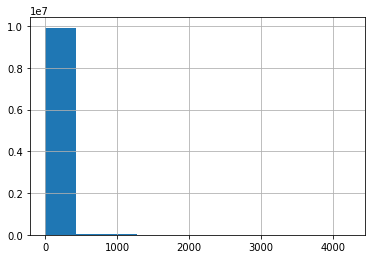

In [12]:
cash['SK_DPD'].hist()

<AxesSubplot:>

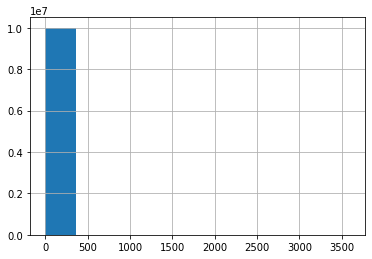

In [13]:
cash['SK_DPD_DEF'].hist()

## feature engg

left skewed - months_balance,<br>
right skewed - CNT_INSTALMENT, CNT_INSTALMENT_FUTURE,

In [7]:
cash['pos_cash_paid_late'] = (cash['SK_DPD'] > 0).astype(int)
cash['pos_cash_paid_late_with_tolerance'] = (cash['SK_DPD_DEF'] > 0).astype(int)

In [170]:
cash['pos_cash_paid_late'].unique()

array([0, 1])

In [120]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 10 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   SK_ID_PREV                         int64  
 1   SK_ID_CURR                         int64  
 2   MONTHS_BALANCE                     int64  
 3   CNT_INSTALMENT                     float64
 4   CNT_INSTALMENT_FUTURE              float64
 5   NAME_CONTRACT_STATUS               object 
 6   SK_DPD                             int64  
 7   SK_DPD_DEF                         int64  
 8   pos_cash_paid_late                 int64  
 9   pos_cash_paid_late_with_tolerance  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 763.0+ MB


In [ ]:
#Convert flag variables to categorical?

## merge train and POS cash dataset

In [44]:
cash_train = cash.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [45]:
cash_train = cash_train.filter(['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','NAME_CONTRACT_STATUS','SK_DPD','pos_cash_paid_late_with_tolerance','pos_cash_paid_late','SK_DPD_DEF','TARGET'], axis=1)


In [169]:
cash_train.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,pos_cash_paid_late_with_tolerance,pos_cash_paid_late,SK_DPD_DEF,TARGET
0,1803195,182943,3.465736,3.891820,3.828641,Active,0,0,0,0,0
1,1803195,182943,2.890372,3.891820,3.465736,Active,0,0,0,0,0
2,1803195,182943,3.091042,3.891820,3.583519,Active,0,0,0,0,0
3,1803195,182943,2.197225,3.891820,3.091042,Active,0,0,0,0,0
4,1803195,182943,1.609438,3.891820,2.890372,Active,0,0,0,0,0
5,1803195,182943,1.098612,3.891820,2.772589,Active,0,0,0,0,0
6,1803195,182943,3.218876,3.891820,3.663562,Active,0,0,0,0,0
7,1803195,182943,2.484907,3.891820,3.258097,Active,0,0,0,0,0
8,1803195,182943,1.386294,3.891820,2.833213,Active,0,0,0,0,0
9,1803195,182943,2.397895,3.891820,3.178054,Active,0,0,0,0,0


## correlation with target

In [54]:
corr_matrix = cash_train.corr()
display(corr_matrix["TARGET"])

SK_ID_PREV                          -0.000056
SK_ID_CURR                          -0.002245
MONTHS_BALANCE                       0.020147
CNT_INSTALMENT                       0.018506
CNT_INSTALMENT_FUTURE                0.021972
SK_DPD                               0.009866
pos_cash_paid_late_with_tolerance    0.017128
pos_cash_paid_late                   0.017466
SK_DPD_DEF                           0.008594
TARGET                               1.000000
Name: TARGET, dtype: float64

In [121]:
#correlation to target improves with newly engineered features

In [ ]:
#TO-DO check correlation for NAME_CONTRACT_STATUS(cat var)

In [123]:
cash_train.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,pos_cash_paid_late_with_tolerance,pos_cash_paid_late,SK_DPD_DEF,TARGET
0,1803195,182943,-31,48.0,45.0,Active,0,0,0,0,0
1,1803195,182943,-17,48.0,31.0,Active,0,0,0,0,0
2,1803195,182943,-21,48.0,35.0,Active,0,0,0,0,0
3,1803195,182943,-8,48.0,21.0,Active,0,0,0,0,0
4,1803195,182943,-4,48.0,17.0,Active,0,0,0,0,0


## cleaning skew and -ve values

In [8]:
def fix_skew_months(X):
    mask = X > 0
    X[mask] = np.NaN
    return np.log1p(-1*X)

def fix_skew(X):
    return np.log1p(X)

In [9]:
cash_train['MONTHS_BALANCE'].hist()

NameError: name 'cash_train' is not defined

In [126]:
cash_train['MONTHS_BALANCE'] = fix_skew_months(cash_train['MONTHS_BALANCE'])

<AxesSubplot:>

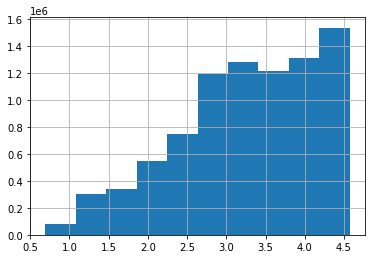

In [127]:
cash_train['MONTHS_BALANCE'].hist()

<AxesSubplot:>

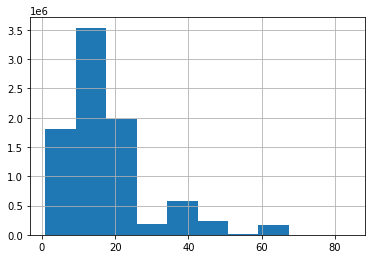

In [128]:
cash_train['CNT_INSTALMENT'].hist()

In [129]:
cash_train['CNT_INSTALMENT'] = fix_skew(cash_train['CNT_INSTALMENT'])

<AxesSubplot:>

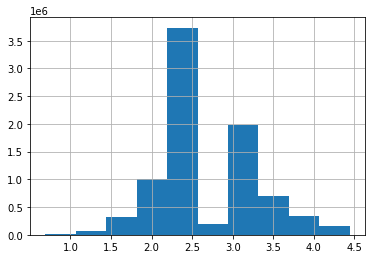

In [130]:
cash_train['CNT_INSTALMENT'].hist()

<AxesSubplot:>

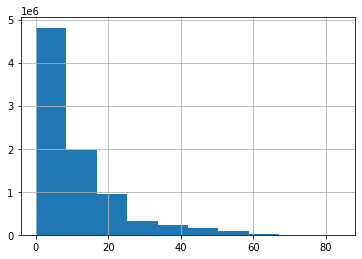

In [131]:
cash_train['CNT_INSTALMENT_FUTURE'].hist()

In [132]:
cash_train['CNT_INSTALMENT_FUTURE'] = fix_skew(cash_train['CNT_INSTALMENT_FUTURE'])

<AxesSubplot:>

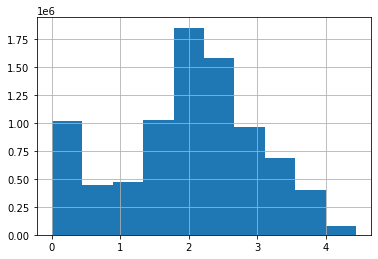

In [133]:
cash_train['CNT_INSTALMENT_FUTURE'].hist()

# Installment dataset

In [112]:
install = pd.read_csv("home-credit-default-risk/installments_payments.csv")
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [134]:
install.nunique()

SK_ID_PREV                997752
SK_ID_CURR                339587
NUM_INSTALMENT_VERSION        65
NUM_INSTALMENT_NUMBER        277
DAYS_INSTALMENT             2922
DAYS_ENTRY_PAYMENT          3039
AMT_INSTALMENT            902539
AMT_PAYMENT               944235
dtype: int64

In [135]:
install.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


## missing values

In [137]:
percent = (install.isnull().sum()/install.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = install.isna().sum().sort_values(ascending = False)
missing_installment_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "installment Missing Count"])
missing_installment_data.head(20)

,Percent,installment Missing Count
DAYS_ENTRY_PAYMENT,0.02,2905
AMT_PAYMENT,0.02,2905
SK_ID_PREV,0.00,0
SK_ID_CURR,0.00,0
NUM_INSTALMENT_VERSION,0.00,0
NUM_INSTALMENT_NUMBER,0.00,0
DAYS_INSTALMENT,0.00,0
AMT_INSTALMENT,0.00,0


In [ ]:
# missing values set to zero would imply no payment was done

In [150]:
any(install['AMT_INSTALMENT']<install['AMT_PAYMENT'])

True

In [ ]:
# can installment value be less than paid amount, if not we can't use mean for missing values.

## feature engg

In [159]:
install['installment_payment_diff'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
# install['installment_paid_in_full'] = 1 if install['installment_payment_diff']<= 0 else 0
install['installment_paid_in_full'] = np.where(install['installment_payment_diff']<= 0, 1, 
                                               np.where(install['installment_payment_diff']>100.00,0,1))

In [162]:
install['installment_days_diff'] = install['DAYS_INSTALMENT'] - install['DAYS_ENTRY_PAYMENT']
# install['installment_paid_in_full'] = 1 if install['installment_payment_diff']<= 0 else 0
install['installment_paid_in_time'] = np.where(install['installment_days_diff']>= 0, 1, 0)

In [171]:
install['install_version'] = (install['NUM_INSTALMENT_VERSION'] > 0).astype(int)

In [172]:
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,installment_payment_diff,installment_paid_in_full,installment_days_diff,installment_paid_in_time,install_version
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,0.000,1,7.0,1,1
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.000,1,0.0,1,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.000,1,0.0,1,1
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,0.000,1,8.0,1,1
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,4.455,1,-17.0,0,1


## merge train and installments dataset

In [173]:
install_train = install.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
install_train = install_train.filter(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT',
'DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT','installment_payment_diff',
'installment_paid_in_full','installment_days_diff','installment_paid_in_time','install_version','TARGET'], axis=1)

## correlation with the target

In [174]:
corr_matrix = install_train.corr()
display(corr_matrix["TARGET"])

SK_ID_PREV                 -0.000212
SK_ID_CURR                 -0.002540
NUM_INSTALMENT_VERSION     -0.009896
NUM_INSTALMENT_NUMBER      -0.016190
DAYS_INSTALMENT             0.034974
DAYS_ENTRY_PAYMENT          0.035122
AMT_INSTALMENT             -0.001498
AMT_PAYMENT                -0.003623
installment_payment_diff    0.006376
installment_paid_in_full   -0.026469
installment_days_diff      -0.008012
installment_paid_in_time   -0.025400
install_version            -0.006467
TARGET                      1.000000
Name: TARGET, dtype: float64

## cleaning skew and -ve values

array([[<AxesSubplot:title={'center':'SK_ID_PREV'}>,
        <AxesSubplot:title={'center':'SK_ID_CURR'}>,
        <AxesSubplot:title={'center':'NUM_INSTALMENT_VERSION'}>,
        <AxesSubplot:title={'center':'NUM_INSTALMENT_NUMBER'}>],
       [<AxesSubplot:title={'center':'DAYS_INSTALMENT'}>,
        <AxesSubplot:title={'center':'DAYS_ENTRY_PAYMENT'}>,
        <AxesSubplot:title={'center':'AMT_INSTALMENT'}>,
        <AxesSubplot:title={'center':'AMT_PAYMENT'}>],
       [<AxesSubplot:title={'center':'installment_payment_diff'}>,
        <AxesSubplot:title={'center':'installment_paid_in_full'}>,
        <AxesSubplot:title={'center':'installment_days_diff'}>,
        <AxesSubplot:title={'center':'installment_paid_in_time'}>],
       [<AxesSubplot:title={'center':'install_version'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

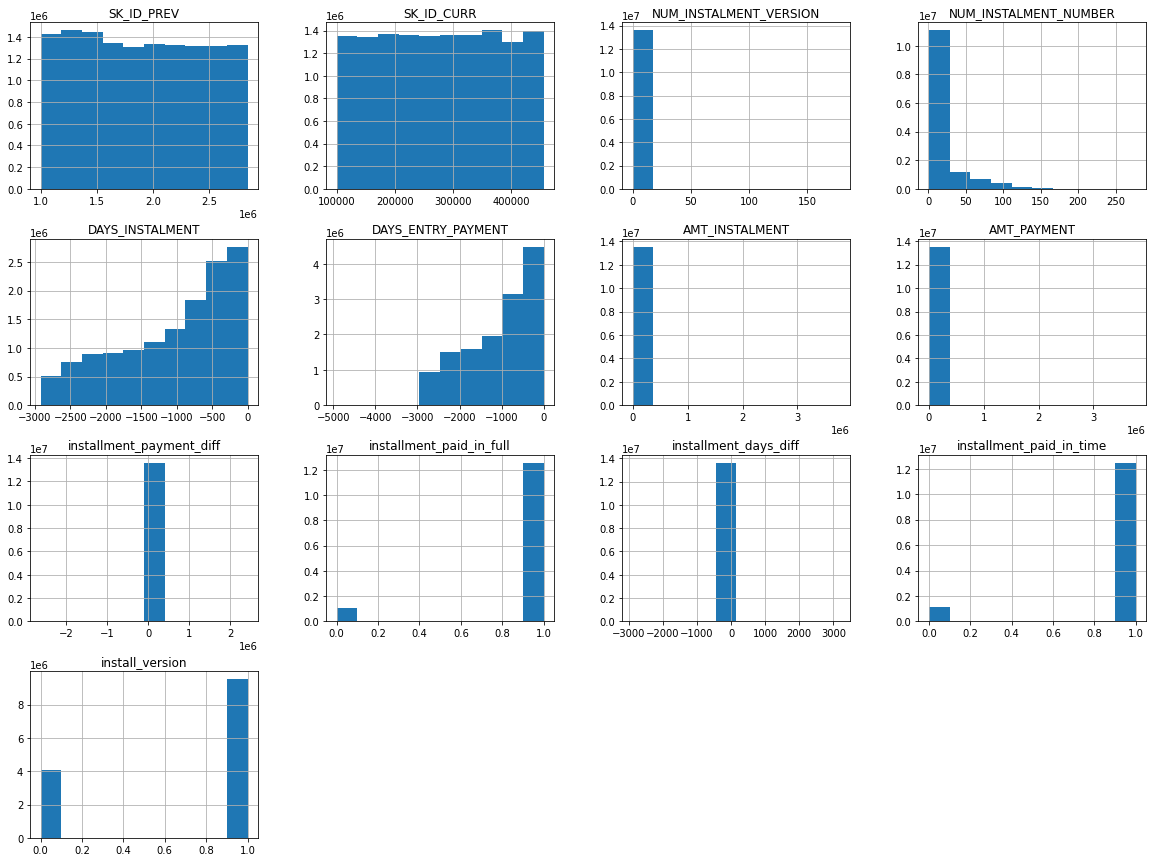

In [175]:
install.hist(figsize=(20,15))

In [ ]:
cash_train['MONTHS_BALANCE'] = fix_skew_months(cash_train['MONTHS_BALANCE'])

# Credit dataset

In [177]:
credit = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [181]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [178]:
percent = (credit.isnull().sum()/credit.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = credit.isna().sum().sort_values(ascending = False)
missing_credit_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "credit Missing Count"])
missing_credit_data.head(20)

,Percent,credit Missing Count
AMT_PAYMENT_CURRENT,20.00,767988
AMT_DRAWINGS_ATM_CURRENT,19.52,749816
CNT_DRAWINGS_POS_CURRENT,19.52,749816
AMT_DRAWINGS_OTHER_CURRENT,19.52,749816
AMT_DRAWINGS_POS_CURRENT,19.52,749816
CNT_DRAWINGS_OTHER_CURRENT,19.52,749816
CNT_DRAWINGS_ATM_CURRENT,19.52,749816
CNT_INSTALMENT_MATURE_CUM,7.95,305236
AMT_INST_MIN_REGULARITY,7.95,305236
SK_ID_PREV,0.00,0


In [188]:
credit_train = credit.merge(application_train, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
credit_train = credit_train.filter(['AMT_PAYMENT_CURRENT','AMT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_POS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT',
'AMT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT','CNT_DRAWINGS_ATM_CURRENT','CNT_INSTALMENT_MATURE_CUM',
'AMT_INST_MIN_REGULARITY','SK_ID_PREV','AMT_TOTAL_RECEIVABLE','SK_DPD','NAME_CONTRACT_STATUS',
'CNT_DRAWINGS_CURRENT','AMT_PAYMENT_TOTAL_CURRENT0','AMT_RECIVABLE','AMT_RECEIVABLE_PRINCIPAL','SK_ID_CURR',
'AMT_DRAWINGS_CURRENT','AMT_CREDIT_LIMIT_ACTUAL','TARGET'], axis=1)

In [189]:
credit_train.shape

(3227965, 20)

In [190]:
corr_matrix = credit_train.corr()
display(corr_matrix["TARGET"])

AMT_PAYMENT_CURRENT           0.012929
AMT_DRAWINGS_ATM_CURRENT      0.024700
CNT_DRAWINGS_POS_CURRENT      0.029536
AMT_DRAWINGS_OTHER_CURRENT    0.003843
AMT_DRAWINGS_POS_CURRENT      0.005084
CNT_DRAWINGS_OTHER_CURRENT    0.003044
CNT_DRAWINGS_ATM_CURRENT      0.038437
CNT_INSTALMENT_MATURE_CUM    -0.023684
AMT_INST_MIN_REGULARITY       0.039798
SK_ID_PREV                    0.002571
AMT_TOTAL_RECEIVABLE          0.049839
SK_DPD                        0.001684
CNT_DRAWINGS_CURRENT          0.037793
AMT_RECIVABLE                 0.049803
AMT_RECEIVABLE_PRINCIPAL      0.049692
SK_ID_CURR                   -0.004617
AMT_DRAWINGS_CURRENT          0.022378
AMT_CREDIT_LIMIT_ACTUAL       0.013823
TARGET                        1.000000
Name: TARGET, dtype: float64

# AGGREGATIONS

## cash transform

In [ ]:
cash = pd.read_csv("home-credit-default-risk/POS_CASH_balance.csv")

In [11]:
# cash.hist(figsize=(20,15))

In [13]:
def cash_transform(cash,inplace=False):
    
    cash['pos_cash_paid_late'] = (cash['SK_DPD'] > 0).astype(int)
    cash['pos_cash_paid_late_with_tolerance'] = (cash['SK_DPD_DEF'] > 0).astype(int)
    
    def fix_skew_months(X):
        mask = X > 0
        X[mask] = np.NaN
        X = np.log(1+np.max(X)-X)
        return -X

    cash['MONTHS_BALANCE'] = fix_skew_months(cash['MONTHS_BALANCE'])
    cash['CNT_INSTALMENT'] = np.log1p(cash['CNT_INSTALMENT'])
    cash['CNT_INSTALMENT_FUTURE'] = np.log1p(cash['CNT_INSTALMENT_FUTURE'])
    
    return cash


## agg-cash

In [16]:
def cashAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations 
    if inplace:
        df_new = df
    else:
        df_new = df.copy()
        
    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()}) 
    
    agg_dict = {
        'MONTHS_BALANCE': ["min", "max", "mean", "sum", "var"],
        'CNT_INSTALMENT': ["min", "max", "mean", "sum", "var"],
        'CNT_INSTALMENT_FUTURE': ["min", "max", "mean", "sum", "var"],
        'SK_DPD':["min", "max", "mean", "sum", "var"],
        'SK_DPD_DEF':["min", "max", "mean", "sum", "var"],
        'pos_cash_paid_late':["mean"],
        'pos_cash_paid_late_with_tolerance':["mean"]
        }
    
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')
    
    return aggr_df

In [17]:
# cash = datasets['POS_CASH_balance']
cashData_aggr = cashAppsFeaturesAggregater(cash_transform(cash))
cashData_aggr,cashData_aggr.shape

(        SK_ID_CURR  MONTHS_BALANCE_min  MONTHS_BALANCE_max  \
 0           182943           -1.634547           -0.526589   
 1           367990           -1.689882           -1.327761   
 2           397406           -1.712589           -0.000000   
 3           269225           -1.698530           -0.000000   
 4           334279           -1.702680           -0.000000   
 ...            ...                 ...                 ...   
 337247      185413           -0.526589           -0.526589   
 337248      326688           -0.526589           -0.526589   
 337249      394310           -0.000000           -0.000000   
 337250      240059           -0.000000           -0.000000   
 337251      144536           -0.000000           -0.000000   
 
         MONTHS_BALANCE_mean  MONTHS_BALANCE_sum  MONTHS_BALANCE_var  \
 0                 -1.358958          -58.435202            0.063458   
 1                 -1.506099          -40.664667            0.015690   
 2                 -1.4551

## installments transform

In [30]:
install = pd.read_csv("home-credit-default-risk/installments_payments.csv")

array([[<AxesSubplot:title={'center':'SK_ID_PREV'}>,
        <AxesSubplot:title={'center':'SK_ID_CURR'}>,
        <AxesSubplot:title={'center':'NUM_INSTALMENT_VERSION'}>],
       [<AxesSubplot:title={'center':'NUM_INSTALMENT_NUMBER'}>,
        <AxesSubplot:title={'center':'DAYS_INSTALMENT'}>,
        <AxesSubplot:title={'center':'DAYS_ENTRY_PAYMENT'}>],
       [<AxesSubplot:title={'center':'AMT_INSTALMENT'}>,
        <AxesSubplot:title={'center':'AMT_PAYMENT'}>, <AxesSubplot:>]],
      dtype=object)

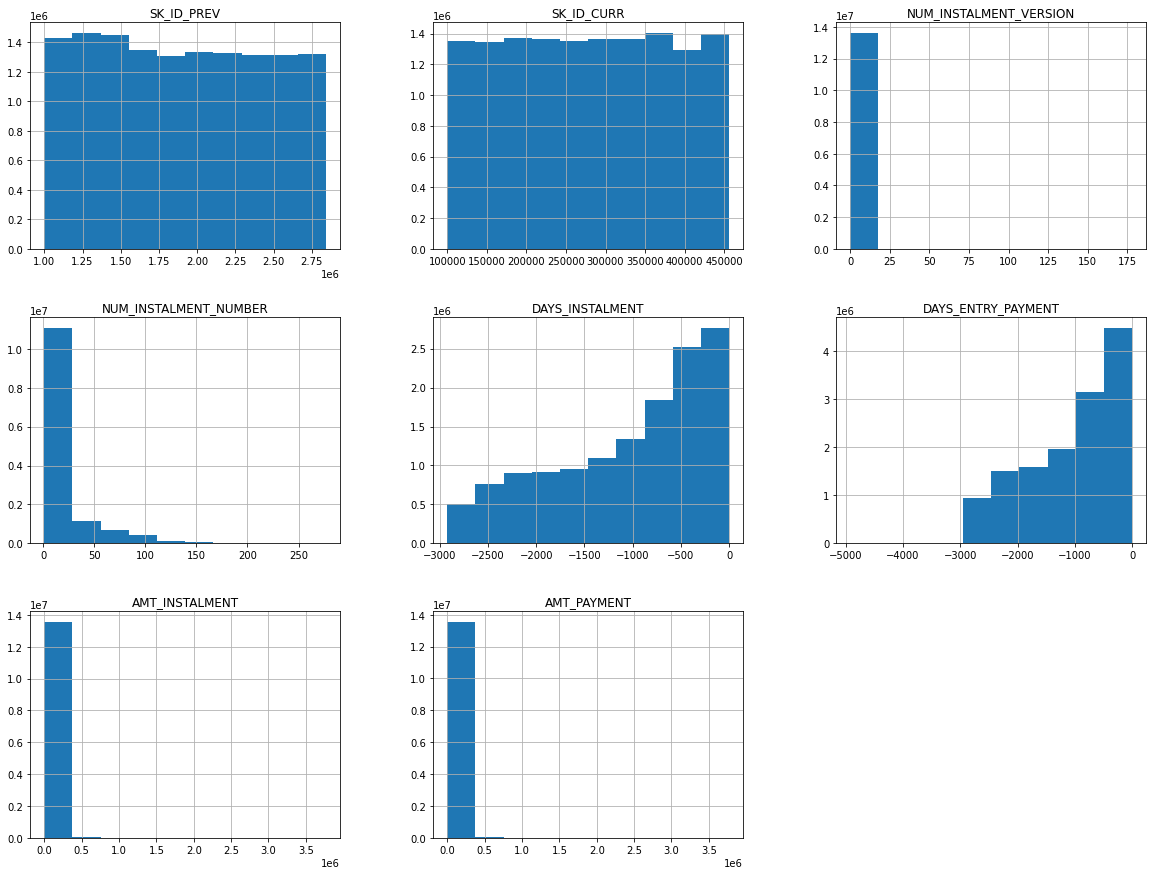

In [20]:
install.hist(figsize=(20,15))

In [25]:
def install_transform(install,inplace=False):
    
    install['installment_payment_diff'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['installment_paid_in_full'] = np.where(install['installment_payment_diff']<= 0, 1, 
                                                   np.where(install['installment_payment_diff']>100.00,0,1))
    
    install['installment_days_diff'] = install['DAYS_INSTALMENT'] - install['DAYS_ENTRY_PAYMENT']
    install['installment_paid_in_time'] = np.where(install['installment_days_diff']>= 0, 1, 0)
    
    install['install_version'] = (install['NUM_INSTALMENT_VERSION'] > 0).astype(int)
    
    def left_skew_days(X):
        mask = X > 0
        X[mask] = np.NaN
        X = np.log(1+np.max(X)-X)
        return -X

    left_skewed = ['DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT']
    install[left_skewed] = left_skew_days(install[left_skewed])
    install['NUM_INSTALMENT_NUMBER'] = np.log1p(install['NUM_INSTALMENT_NUMBER'])
    
    return install

## agg- installments

In [35]:
def instlmntAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations 
    if inplace:
        df_new = df
    else:
        df_new = df.copy()
        
    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})
    
    # Compute min, max, min values
    agg_dict = {
        'NUM_INSTALMENT_VERSION':["min", "max", "mean", "sum", "var"],
       'NUM_INSTALMENT_NUMBER':["min", "max", "mean", "sum", "var"],
        'DAYS_INSTALMENT':["min", "max", "mean", "sum", "var"], 
        'DAYS_ENTRY_PAYMENT':["min", "max", "mean", "sum", "var"],
       'AMT_INSTALMENT':["min", "max", "mean", "sum", "var"], 
        'AMT_PAYMENT':["min", "max", "mean", "sum", "var"],
        'installment_payment_diff':["min", "max", "mean", "sum", "var"],
       'installment_paid_in_full':["mean"], 
        'installment_days_diff':["min", "max", "mean", "sum", "var"],
       'installment_paid_in_time':["mean"],
        'install_version':["mean"]
            } 
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')
    
    return aggr_df

In [36]:
# install = datasets['installments_payments']
instlmntData_aggr = instlmntAppsFeaturesAggregater(install_transform(install))
instlmntData_aggr,instlmntData_aggr.shape

(        SK_ID_CURR  NUM_INSTALMENT_VERSION_min  NUM_INSTALMENT_VERSION_max  \
 0           161674                         1.0                         2.0   
 1           151639                         0.0                         2.0   
 2           193053                         2.0                         3.0   
 3           199697                         1.0                         3.0   
 4           167756                         1.0                         2.0   
 ...            ...                         ...                         ...   
 339582      427056                         1.0                         1.0   
 339583      434108                         2.0                         2.0   
 339584      413433                         2.0                         2.0   
 339585      434445                         2.0                         2.0   
 339586      405063                         0.0                         0.0   
 
         NUM_INSTALMENT_VERSION_mean  NUM_INSTALME

In [37]:
credit = pd.read_csv("home-credit-default-risk/credit_card_balance.csv")

array([[<AxesSubplot:title={'center':'SK_ID_PREV'}>,
        <AxesSubplot:title={'center':'SK_ID_CURR'}>,
        <AxesSubplot:title={'center':'MONTHS_BALANCE'}>,
        <AxesSubplot:title={'center':'AMT_BALANCE'}>,
        <AxesSubplot:title={'center':'AMT_CREDIT_LIMIT_ACTUAL'}>],
       [<AxesSubplot:title={'center':'AMT_DRAWINGS_ATM_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_DRAWINGS_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_DRAWINGS_OTHER_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_DRAWINGS_POS_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_INST_MIN_REGULARITY'}>],
       [<AxesSubplot:title={'center':'AMT_PAYMENT_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_PAYMENT_TOTAL_CURRENT'}>,
        <AxesSubplot:title={'center':'AMT_RECEIVABLE_PRINCIPAL'}>,
        <AxesSubplot:title={'center':'AMT_RECIVABLE'}>,
        <AxesSubplot:title={'center':'AMT_TOTAL_RECEIVABLE'}>],
       [<AxesSubplot:title={'center':'CNT_DRAWINGS_ATM_CURRENT'}>,

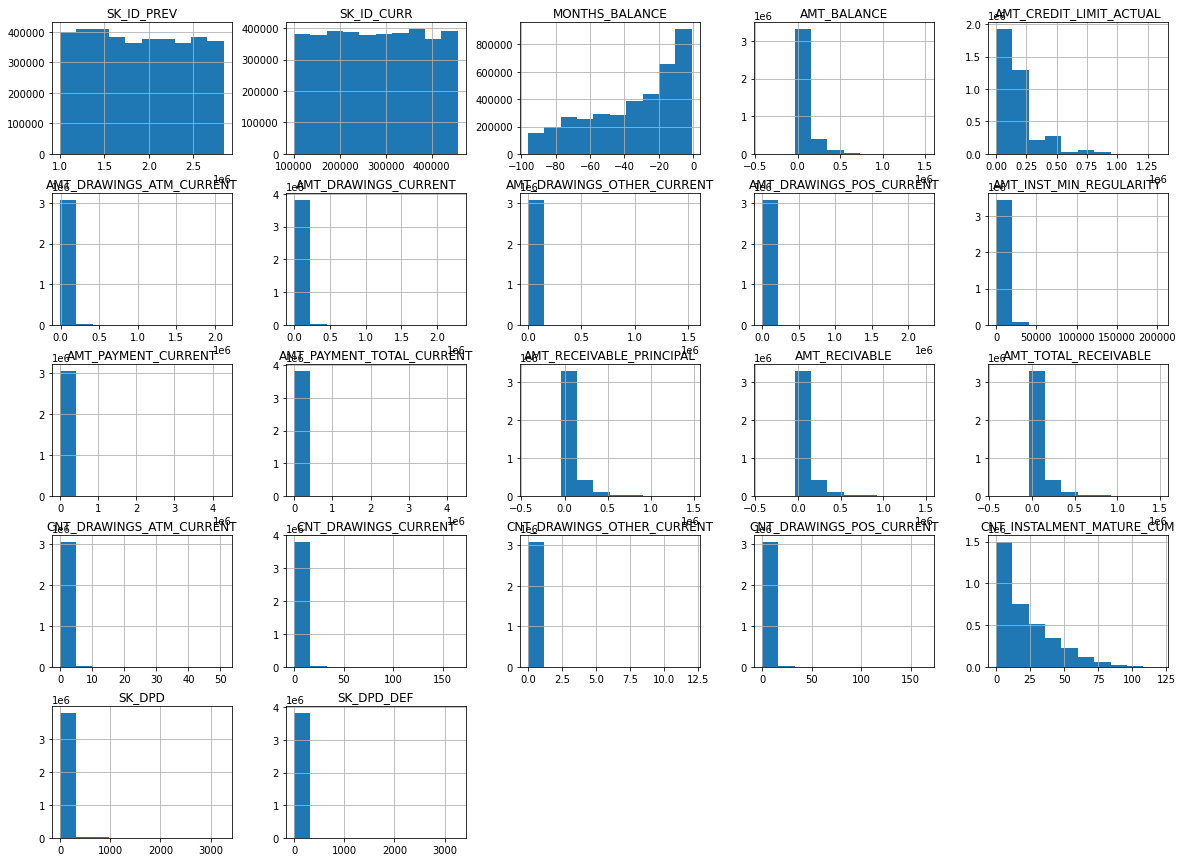

In [38]:
credit.hist(figsize=(20,15))

In [39]:
def credit_transform(credit,inplace=False):
    
       # Amount used from limit
    credit['limit_use'] = credit['AMT_BALANCE'] / credit['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    credit['payment_div_min'] = credit['AMT_PAYMENT_CURRENT'] / credit['AMT_INST_MIN_REGULARITY']
    # Late payment <-- 'CARD_IS_DPD'
    credit['late_payment'] = credit['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    credit['drawing_limit_ratio'] = credit['AMT_DRAWINGS_ATM_CURRENT'] / credit['AMT_CREDIT_LIMIT_ACTUAL']
    
    def right_skew(X): return np.log1p(X)
    
    right_skewed = ['AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE',
                   'AMT_TOTAL_RECEIVABLE','CNT_INSTALMENT_MATURE_CUM']
    credit[right_skewed] = right_skew(credit[ right_skewed])
    
    return credit

In [40]:
credit_transform(credit).columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF', 'limit_use', 'payment_div_min', 'late_payment',
       'drawing_limit_ratio'],
      dtype='object')

In [43]:
def creditAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations 
    if inplace:
        df_new = df
    else:
        df_new = df.copy()
        
    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})
    
    # Compute min, max, min values
    agg_dict = {
       'AMT_BALANCE':["min", "max", "mean", "sum", "var"],
       'AMT_CREDIT_LIMIT_ACTUAL':["min", "max", "mean", "sum", "var"], 
        'AMT_DRAWINGS_ATM_CURRENT':["min", "max", "mean", "sum", "var"],
       'AMT_DRAWINGS_CURRENT':["min", "max", "mean", "sum", "var"], 
        'AMT_DRAWINGS_OTHER_CURRENT':["min", "max", "mean", "sum", "var"],
       'AMT_DRAWINGS_POS_CURRENT':["min", "max", "mean", "sum", "var"], 
        'AMT_INST_MIN_REGULARITY':["min", "max", "mean", "sum", "var"],
       'AMT_PAYMENT_CURRENT':["min", "max", "mean", "sum", "var"], 
        'AMT_PAYMENT_TOTAL_CURRENT':["min", "max", "mean", "sum", "var"],
       'AMT_RECEIVABLE_PRINCIPAL':["min", "max", "mean", "sum", "var"], 
        'AMT_RECIVABLE':["min", "max", "mean", "sum", "var"], 
        'AMT_TOTAL_RECEIVABLE':["min", "max", "mean", "sum", "var"],
       'CNT_DRAWINGS_ATM_CURRENT':["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_CURRENT':["min", "max", "mean", "sum", "var"],
       'CNT_DRAWINGS_OTHER_CURRENT':["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_POS_CURRENT':["min", "max", "mean", "sum", "var"],
       'CNT_INSTALMENT_MATURE_CUM':["min", "max", "mean", "sum", "var"],
        'SK_DPD':["min", "max", "mean", "sum", "var"],
       'SK_DPD_DEF':["min", "max", "mean", "sum", "var"],
        'limit_use':["min", "max", "mean", "sum", "var"],
        'payment_div_min':["min", "max", "mean", "sum", "var"], 
        'late_payment':["mean"],
       'drawing_limit_ratio':["min", "max", "mean", "sum", "var"]
            } 
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')
    
    return aggr_df

In [44]:
#credit = datasets['credit_card_balance']
creditData_aggr = creditAppsFeaturesAggregater(credit_transform(credit))
creditData_aggr,creditData_aggr.shape

(        SK_ID_CURR  AMT_BALANCE_min  AMT_BALANCE_max  AMT_BALANCE_mean  \
 0           378907         0.000000         1.251872          0.997947   
 1           363914         0.000000         1.253120          0.849475   
 2           371185         0.000000         1.282049          1.224667   
 3           337855         1.206980         1.279190          1.268322   
 4           126868         1.143678         1.292545          1.269944   
 ...            ...              ...              ...               ...   
 103553      403596         0.000000         0.000000          0.000000   
 103554      318916         0.000000         0.000000          0.000000   
 103555      174455         0.000000         0.000000          0.000000   
 103556      315041         0.000000         0.000000          0.000000   
 103557      382749         0.000000         0.000000          0.000000   
 
         AMT_BALANCE_sum  AMT_BALANCE_var  AMT_CREDIT_LIMIT_ACTUAL_min  \
 0             46.903529